# Age Verification with Computer Vision for Alcohol Sales Compliance

To ensure compliance with alcohol sale laws, the supermarket chain Good Seed is interested in using computer vision to automatically verify a customer’s age at the point of sale using camera footage captured during alcohol transactions.

This project focuses on building and evaluating a machine learning model capable of estimating a person's age based on their facial features using a dataset of photographs labeled with the individuals’ real ages. The goal is to develop a reliable computer vision system that can assist staff in real time by flagging potentially underage customers, thereby supporting legal compliance and enhancing operational efficiency by not requiring checks of every customer.

## Initialization

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import matplotlib.pyplot as plt
import numpy as np

## Load Data

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=21)

Found 7591 validated image filenames.


The dataset contains 7591 different images, which have been loaded so that pixel values are normalized.  I also loaded a CSV file with the actual ages of each individual and assigned the information to each of the photos.  All images have been resized to 224x224 and divided into batches of 32.

## EDA

In [3]:
print("The minimum age of individuals in the pictures is:", labels.min())
(print("The maximum age of individuals in the pictures is:", labels.max()))

The minimum age of individuals in the pictures is: file_name    000000.jpg
real_age              1
dtype: object
The maximum age of individuals in the pictures is: file_name    007612.jpg
real_age            100
dtype: object


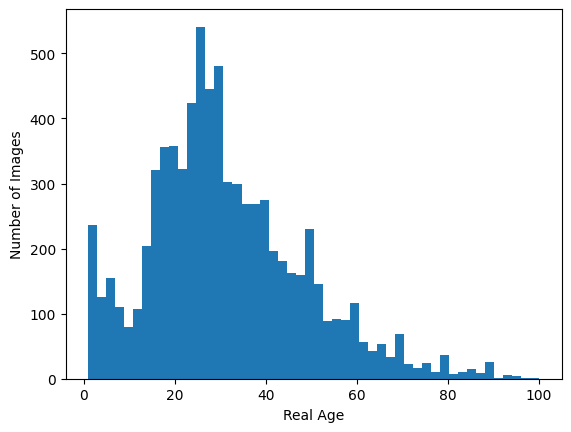

In [11]:
plt.hist(labels['real_age'], bins=50)
plt.xlabel('Real Age')
plt.ylabel('Number of Images')
plt.title('Age Distribution')
plt.show()

The dataset is comprehensive and useful for this analysis as it contains photos of individuals from age 1 to 100.  The images primarily represent a late teen/young adult population (15-30), though it also contains a sizable number of young child images.

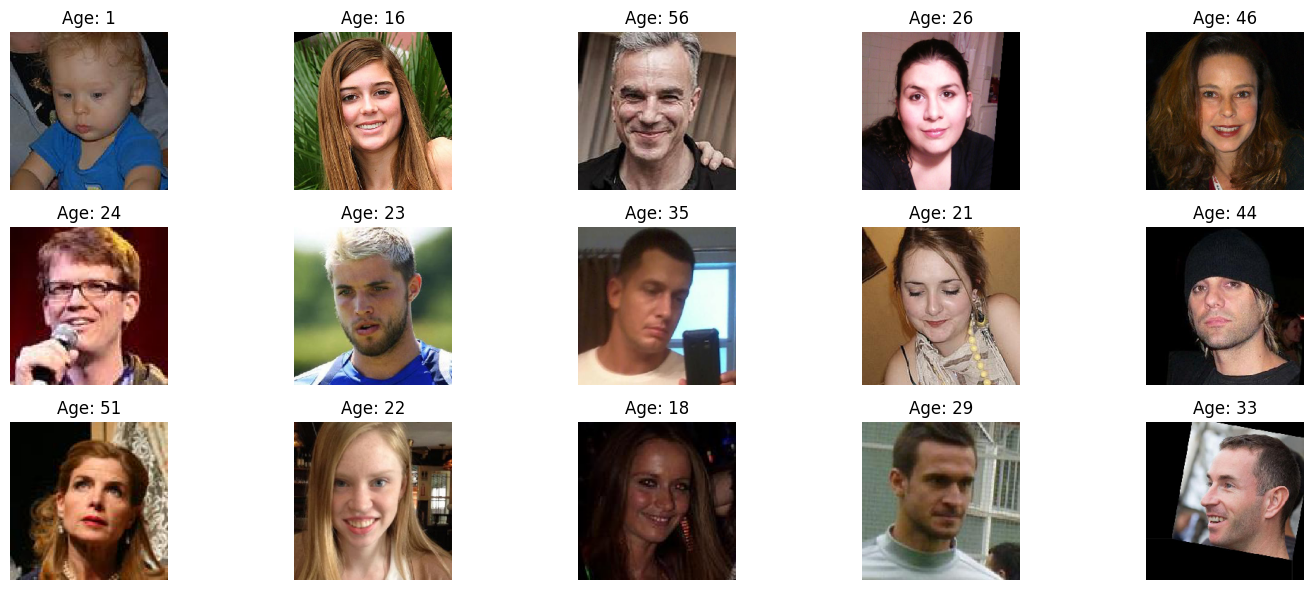

In [14]:
# Keep track of shown ages to avoid duplicates
shown_ages = set()
images_to_show = []
labels_to_show = []

# Loop over batches until we collect 10–15 unique ages
for images, labels in train_gen_flow:
    for img, age in zip(images, labels):
        rounded_age = int(round(age))  # Round to simplify uniqueness
        if rounded_age not in shown_ages:
            shown_ages.add(rounded_age)
            images_to_show.append(img)
            labels_to_show.append(rounded_age)
        if len(images_to_show) >= 15:
            break
    if len(images_to_show) >= 15:
        break

# Plot the collected images
fig = plt.figure(figsize=(15, 6))
for i in range(len(images_to_show)):
    ax = fig.add_subplot(3, 5, i + 1)
    ax.imshow(images_to_show[i])
    ax.set_title(f'Age: {labels_to_show[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

### Findings

The 7591 images include individuals between the ages of 1 and 100 or various genders, races, and ethnicities.  Most of the images are in color, but some are black and white.  The individuals have various expressions.  Most are looking at the camera or otherwise have their entire face visible, but some are photographed in profile.  The variety of images in the dataset should allow the model to reasonably predict ages for a variety of photos.

## Modelling

In [15]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [3]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    seed = 21
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

    train_gen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                                 directory=path,
                                                 x_col='file_name',
                                                 y_col='real_age',
                                                 target_size=(224, 224),
                                                 subset = 'training',
                                                 class_mode='raw',
                                                 shuffle=True,
                                                 seed = seed)
                                                 

    return train_gen_flow

In [4]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    seed = 21
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

    train_gen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                                 directory=path,
                                                 x_col='file_name',
                                                 y_col='real_age',
                                                 target_size=(224, 224),
                                                 subset = 'validation',
                                                 class_mode='raw',
                                                 shuffle=False,
                                                 seed = seed)

    return test_gen_flow

In [19]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [20]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
        
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

## Preparing the Script to Run on the GPU Platform

In [21]:
# prepare a script to run on the GPU platform
init_str = '''
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
'''
import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

```python
Epoch 1/20
356/356 - 35s - loss: 95.3532 - mae: 7.4339 - val_loss: 124.3362 - val_mae: 8.4921  
Epoch 2/20
356/356 - 35s - loss: 76.8372 - mae: 6.6707 - val_loss: 127.6357 - val_mae: 8.6035
Epoch 3/20
356/356 - 35s - loss: 69.9428 - mae: 6.3992 - val_loss: 91.1531 - val_mae: 7.4454
Epoch 4/20
356/356 - 35s - loss: 64.4249 - mae: 6.1407 - val_loss: 124.0287 - val_mae: 8.3481
Epoch 5/20
356/356 - 35s - loss: 52.8486 - mae: 5.5913 - val_loss: 109.1004 - val_mae: 8.2192
Epoch 6/20
356/356 - 35s - loss: 46.3094 - mae: 5.2223 - val_loss: 85.1038 - val_mae: 7.0332
Epoch 7/20
356/356 - 35s - loss: 38.2617 - mae: 4.7951 - val_loss: 92.0900 - val_mae: 7.3359
Epoch 8/20
356/356 - 35s - loss: 37.4804 - mae: 4.7402 - val_loss: 80.0016 - val_mae: 6.7239
Epoch 9/20
356/356 - 35s - loss: 33.5237 - mae: 4.4271 - val_loss: 83.2579 - val_mae: 6.8529
Epoch 10/20
356/356 - 35s - loss: 28.5170 - mae: 4.1411 - val_loss: 83.5056 - val_mae: 6.9629
Epoch 11/20
356/356 - 35s - loss: 27.0142 - mae: 3.9700 - val_loss: 92.1290 - val_mae: 7.1866
Epoch 12/20
356/356 - 35s - loss: 27.4564 - mae: 4.0428 - val_loss: 185.6307 - val_mae: 11.4591
Epoch 13/20
356/356 - 35s - loss: 23.7961 - mae: 3.7407 - val_loss: 92.3429 - val_mae: 7.2467
Epoch 14/20
356/356 - 35s - loss: 24.6167 - mae: 3.8116 - val_loss: 92.4542 - val_mae: 7.1401
Epoch 15/20
356/356 - 35s - loss: 22.2604 - mae: 3.6746 - val_loss: 82.5822 - val_mae: 6.7841
Epoch 16/20
356/356 - 35s - loss: 20.1899 - mae: 3.4430 - val_loss: 86.3830 - val_mae: 6.8304
Epoch 17/20
356/356 - 35s - loss: 17.3425 - mae: 3.2205 - val_loss: 78.4369 - val_mae: 6.6419
Epoch 18/20
356/356 - 35s - loss: 16.5249 - mae: 3.1295 - val_loss: 81.7731 - val_mae: 6.7226
Epoch 19/20
356/356 - 35s - loss: 16.6140 - mae: 3.1421 - val_loss: 80.9727 - val_mae: 6.9908
Epoch 20/20
356/356 - 35s - loss: 17.0187 - mae: 3.1785 - val_loss: 93.4115 - val_mae: 7.6512
```

## Conclusions

This project created a convulutional neural network to complete a regression task using the ResNet50 backbone and Adam optimizer.  A single nonnegative output is produced estimating the age of an individual based on their facial features.  The model successfully learned from the data, but has some peculiarities, such as a curious spike in the validation set's loss and MAE at 12 epochs.  At 17 epochs, it achieves its lowest mean absolute error of 6.642 and loss of 3.221 on the validation set.  The training set's metrics continue to improve past this point, but the model is becoming overfitted given its validation metrics do not continue to improve.  Early stopping should be used to get the most accurate result.

While computer vision is not accurate enough to ensure alcohol is not sold to those underage, it could certainly be used to notify staff that an ID check is necessary when the predicted age is +/-7 years of the legal drinking age without requiring a check of every customer.  The MAE at 17 epochs is within Good Seed's requested accuracy of within 8 years.

The model could be improved in future by expanding the facial dataset to allow for greater recognition capabilities.  While this is a good starter set, more images for the model to learn from could increase accuracy.  An ideal set would perhaps only include those within a reasonable age to consider buying alcohol, i.e. above 10 years of age.

Additional applications are possible for this model.  It could be used to flag when ID checks are necessary for other restricted products such as cigarettes.  This model could also be used to track the ages of consumers buying any product for marketing purposes.  Given the model's limitations in predicting age with a high degree of reliability, that may in fact be a better use of the model.